# CONVERT ONNX MODELS TO TensorRT AND BENCHMARK
Colab Notebook [Link](https://colab.research.google.com/drive/1hPajI-7neicbFXGCtNrPPDLkRb4JQgpb?usp=sharing).

# IMPORTS

In [1]:
!pip install onnx tensorrt pycuda

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 87.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.6/88.6 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.2 MB/s eta 0:00:00
  Created wheel for tensorrt: filename=tensorrt-10.6.0-py2.py3-none-any.whl size=16336 sha256=aa0f60a71f96efc548480964caad62214acec902efbc85c469c28e1a6b342506
  Stored in directory: /root/.cache/pip/wheels/2a/97/95/8fdbe17369eed28ee9903523b94e130023ae58edcf1c904e5a
  Created wheel for tensorrt-cu12: filename=tensorrt_cu12-10.6.0-py2.py3-none-any.whl size=17549 sha256=c7bccebfd1a29deaa7fc5916ffa45aaed5075ce5d892417087bac08fb39aaae9
  Stored in directory: /root/.cach

In [2]:
!pip install cuda-python>=12.2.0

In [3]:
import numpy as np
import pandas as pd
import time
import os

# Torch imports
import torch
import torch.nn as nn
import torch.optim as optim

# Onnx imports
import torch.onnx
import onnx

# TensorRT imports
import tensorrt as trt
from tensorrt import TensorIOMode # VERY USEFUL!

# Needed for inference
import pycuda.driver as cuda
import pycuda.autoinit

# Colab bug
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [4]:
DEVICE = 'cuda'

# Start with a Simple Network

In [6]:
# Simple NN
# TensorRT Gives upto 10x speedup
class SimpleNN(nn.Module):
    def __init__(self):
        # super(SimpleNN, self).__init__()
        super().__init__()
        self.fc1 = nn.Linear(10, 5)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(5, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


small_model = SimpleNN()
small_model.to(DEVICE)
small_model

SimpleNN(
  (fc1): Linear(in_features=10, out_features=5, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=5, out_features=1, bias=True)
)

In [19]:
# Slightly deeper model
# TensorRT Gives upto 10x speedup too
class DeepNN(nn.Module):
    def __init__(self):
        super().__init__()

        # Slightly deeper model
        self.model = nn.Sequential(
            nn.Linear(10, 640),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(640, 1280),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(1280, 640),
            nn.ReLU(),

            nn.Linear(640, 1)
        )

    def forward(self, x):
        return self.model(x)

deep_model = DeepNN()
deep_model.to(DEVICE)

DeepNN(
  (model): Sequential(
    (0): Linear(in_features=10, out_features=640, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=640, out_features=1280, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=1280, out_features=640, bias=True)
    (7): ReLU()
    (8): Linear(in_features=640, out_features=1, bias=True)
  )
)

In [22]:
# Trying to mimic a much larger model - have kept 32 layers with hidden size 2048
# Creating the model engine takes much more time! About 2 minutes.
# Still saw upto 5x speedups :)

class SuperDeepNN(nn.Module):
    def __init__(self):
        super().__init__()

        # Create a list of layers
        layers = []
        input_size = 10
        hidden_size = 2048

        # 32 linear layers
        for i in range(32):
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.5))

            input_size = hidden_size

        layers.append(nn.Linear(hidden_size, 1))

        # Combine all layers
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

super_deep_model = SuperDeepNN()
super_deep_model.to(DEVICE)
print(f'hi!')

hi!


## Measure inference speed
We check for a lot of iterations, for all the three models


In [15]:
def check_fps(model):

  num_iterations = 1000
  total_time = 0.0
  input_shape = (1, 10)

  with torch.no_grad():
      for i in range(num_iterations):
          input_data = torch.randn(*input_shape).to(DEVICE)

          tik = time.time()
          output_data = model(input_data)
          tok = time.time()

          total_time += tok - tik

  # Calculate frames per second (FPS)
  pytorch_fps = num_iterations / total_time

  # print(f"PyTorch FPS: {pytorch_fps:.2f}")

  return pytorch_fps

In [58]:
# RESULTS
# Note: I ran this cell out of order so simply uncommenting may not work :)

num_loops = 10

# SMALL MODEL
small_model_fps = [check_fps(model = small_model) for _ in range(num_loops)]
avg_small_model_fps = np.mean(small_model_fps)
print(f'MEAN SMALL MODEL FPS = {avg_small_model_fps}')
# MEAN SMALL MODEL FPS = 8877.719539737895


# DEEP MODEL
# deep_model_fps = [check_fps(model = deep_model) for _ in range(num_loops)]
# avg_deep_model_fps = np.mean(deep_model_fps)
# print(f'MEAN DEEP MODEL FPS = {avg_deep_model_fps}')
# MEAN DEEP MODEL FPS = 3451.9139936571473


# SUPER DEEP MODEL
# super_deep_model_fps = [check_fps(model = super_deep_model) for _ in range(num_loops)]
# avg_super_deep_model_fps = np.mean(super_deep_model_fps)
# print(f'MEAN DEEP MODEL FPS = {avg_super_deep_model_fps}')
# MEAN DEEP MODEL FPS = 439.697988206109

MEAN SMALL MODEL FPS = 8877.719539737895


## Convert model to onnx
Requires dummy inputs

In [79]:
# We reset this cell for all the models one by one

# Small model
# onnx_model_path = "/content/small_nn.onnx"
# model = small_model
# engine_path = "/content/small_model.engine"

# Deep model
# onnx_model_path = "/content/deep_nn.onnx"
# model = deep_model
# engine_path = "/content/deep_model.engine"

# Super Deep model
onnx_model_path = "/content/super_deep_nn.onnx"
model = super_deep_model
engine_path = "/content/super_deep_model.engine"

In [80]:
dummy_input = torch.randn(1, 10).to(DEVICE)

torch.onnx.export(
    model,
    dummy_input,
    onnx_model_path,
    verbose=True
    )

print(f"Model exported to {onnx_model_path}")

Model exported to /content/super_deep_nn.onnx


In [81]:
# Check if the conversion happened well
model_onnx = onnx.load(onnx_model_path)
print(model_onnx.graph.input)

[name: "onnx::Gemm_0"
type {
  tensor_type {
    elem_type: 1
    shape {
      dim {
        dim_value: 1
      }
      dim {
        dim_value: 10
      }
    }
  }
}
]




---



# Build the TensorRT engine from the ONNX model
Requires a bunch of features to be properly defined, like the logger, the builder etc. All new to me so nice! \
The code blocks below can be seen as **setting up all the variables and features** nicely.

In [82]:
# Set variables

# builder takes the logger as argument. Intersting!
TRT_LOGGER = trt.Logger(trt.Logger.VERBOSE)
builder = trt.Builder(TRT_LOGGER)

config = builder.create_builder_config()
cache = config.create_timing_cache(b"")
config.set_timing_cache(cache, ignore_mismatch=False)

# Explicit batch flags are for handling dynamic shapes
flag = 1 << int(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH)

network = builder.create_network(flag)
parser = trt.OnnxParser(network, TRT_LOGGER)

In [83]:
# Load the onnx model

# They say this is the way to parse the input.
# I find it intersting because this is only checking for errors while parsing :)
with open(onnx_model_path, "rb") as f:
    if not parser.parse(f.read()):
        print(f"ERROR: Failed to parse the ONNX file {onnx_model_path}")
        for error in range(parser.num_errors):
            print(parser.get_error(error))

In [84]:
inputs = [network.get_input(i) for i in range(network.num_inputs)]
outputs = [network.get_output(i) for i in range(network.num_outputs)]
print(f'inputs = {inputs}, outputs = {outputs}')

inputs = [<tensorrt_bindings.tensorrt.ITensor object at 0x7dc2b9e6d870>], outputs = [<tensorrt_bindings.tensorrt.ITensor object at 0x7dc2b9e6f6f0>]


In [85]:
# more settings
config.get_calibration_profile()
builder.platform_has_fast_fp16
trt.BuilderFlag.BF16

<ipython-input-85-7a17a39bcc35>:2: DeprecationWarning: Use Deprecated in TensorRT 10.1. Superseded by explicit quantization. instead.
  config.get_calibration_profile()


<BuilderFlag.BF16: 17>

In [86]:
# Reduce precision
half = True
int8 = False

if half:
    config.set_flag(trt.BuilderFlag.FP16)
elif int8:
    config.set_flag(trt.BuilderFlag.INT8)

In [87]:
# Load without unncessary weights if needed
strip_weights = True
if strip_weights:
    config.set_flag(trt.BuilderFlag.STRIP_PLAN)


In [88]:
# Build the TRT engine file
# Note how this is the serialize method
engine_bytes = builder.build_serialized_network(network, config)

with open(engine_path, "wb") as f:
    f.write(engine_bytes)


## Load the Saved Engine and execute

In [89]:
# Execute engine
# Note how this is the DE-serialize method :)

# This can be loaded in two ways apparently
# The weight stripped engine and the usual engine

def load_stripped_engine_and_refit(
    engine_path: str,
    onnx_model_path: str,
) -> trt.ICudaEngine:

    runtime = trt.Runtime(TRT_LOGGER)
    with open(engine_path, "rb") as engine_file:
        engine = runtime.deserialize_cuda_engine(engine_file.read())
        refitter = trt.Refitter(engine, TRT_LOGGER)
        parser_refitter = trt.OnnxParserRefitter(refitter, TRT_LOGGER)

        assert parser_refitter.refit_from_file(onnx_model_path)
        assert refitter.refit_cuda_engine()
        return engine


def load_normal_engine(
    engine_path: str
) -> trt.ICudaEngine:

    # much simpler without many assertions
    runtime = trt.Runtime(TRT_LOGGER)
    with open(engine_path, "rb") as plan:
        engine = runtime.deserialize_cuda_engine(plan.read())
        return engine

In [90]:
if strip_weights:
    engine = load_stripped_engine_and_refit(engine_path, onnx_model_path)
else:
    engine = load_normal_engine(engine_path)

engine



---



## Inference with the TRT Engine

In [91]:
# Logger as earlier
TRT_LOGGER = trt.Logger(trt.Logger.VERBOSE)

# Path to the 'serialized' TensorRT engine :)
engine_path

'/content/super_deep_model.engine'

In [92]:
# Load the engine
def load_engine(engine_path: str) -> trt.ICudaEngine:

    # observe how this same as earlier
    runtime = trt.Runtime(TRT_LOGGER)

    with open(engine_path, "rb") as f:
        engine = runtime.deserialize_cuda_engine(f.read())
        return engine

engine = load_engine(engine_path)

In [93]:
# wrapping useful methods in a class trtEngineInference
# reference https://docs.nvidia.com/deeplearning/tensorrt/developer-guide/index.html#perform_inference_python

class trtEngineInference:
    def __init__(self, engine_path: str):
        self.engine_path = engine_path
        self.TRT_LOGGER = trt.Logger(trt.Logger.VERBOSE)

        # setup the required things in init only
        self.engine = self.load_engine()
        self.context = self.engine.create_execution_context()
        self.inputs, self.outputs, self.bindings, self.stream = self.allocate_buffers()

    def load_engine(self) -> trt.ICudaEngine:
        runtime = trt.Runtime(self.TRT_LOGGER)
        with open(self.engine_path, "rb") as f:
            return runtime.deserialize_cuda_engine(f.read())

    def allocate_buffers(self):
        inputs = []
        outputs = []
        bindings = []
        stream = cuda.Stream()

        for binding in self.engine:
            binding_name = binding
            binding_shape = self.engine.get_tensor_shape(binding)
            binding_dtype = self.engine.get_tensor_dtype(binding)
            size = trt.volume(binding_shape) * 1 # self.engine.max_batch_size
            dtype = trt.nptype(binding_dtype)

            # Allocate host and device buffers
            host_mem = cuda.pagelocked_empty(size, dtype)
            device_mem = cuda.mem_alloc(host_mem.nbytes)

            # Append the device buffer to device bindings
            bindings.append(int(device_mem))

            # Append to the appropriate list
            # The binding_is_input has been depreciated, but still shows on the documentation ExecutionContextpage, but not on the ICudaEngine page
            # Definitely confusing :/
            # https://developer.nvidia.com/docs/drive/drive-os/6.0.9/public/drive-os-tensorrt/api-reference/docs/python/infer/Core/ExecutionContext.html#tensorrt.IExecutionContext.get_binding_shape
            # https://docs.nvidia.com/deeplearning/tensorrt/api/python_api/infer/Core/Engine.html

            # if engine.binding_is_input(binding):
            # The modes can be TensorIOMode.OUTPUT, TensorIOMode.INPUT, TensorIOMode.NONE,
            # https://docs.nvidia.com/deeplearning/tensorrt/api/python_api/infer/Core/Engine.html

            if self.engine.get_tensor_mode(binding) == trt.TensorIOMode.INPUT:
                inputs.append({'name': binding_name, 'host': host_mem, 'device': device_mem})
            else:
                outputs.append({'name': binding_name, 'host': host_mem, 'device': device_mem})

        return inputs, outputs, bindings, stream

    def prepare_input_data(self, input_data: np.ndarray):
        # Copy input data to the host memory
        np.copyto(self.inputs[0]['host'], input_data.ravel())

        # Set tensor addresses for inputs and outputs
        for inp in self.inputs:
            self.context.set_tensor_address(inp['name'], int(inp['device']))
        for out in self.outputs:
            self.context.set_tensor_address(out['name'], int(out['device']))

    def do_inference(self):
        # Transfer data from CPU to GPU
        [cuda.memcpy_htod_async(inp['device'], inp['host'], self.stream) for inp in self.inputs]

        # Run inference
        self.context.execute_async_v3(stream_handle=self.stream.handle)

        # Transfer predictions back from the GPU.
        [cuda.memcpy_dtoh_async(out['host'], out['device'], self.stream) for out in self.outputs]

        # Synchronize the stream
        self.stream.synchronize()

        # Return only the host outputs.
        return [out['host'] for out in self.outputs]


In [94]:
# Inference for one input
trt_engine = trtEngineInference(engine_path)

input_shape = (1, 10)  # Batch size of 1, 10 features
input_data = np.random.rand(*input_shape).astype(np.float32)
trt_engine.prepare_input_data(input_data)
output_data = trt_engine.do_inference()
output_data

[array([0.02160645], dtype=float32)]


## Measure inference speed

In [77]:
# Note how this little code block is similar to the one done previously for the pytorch model

def check_fps_trt(trt_engine):

  num_iterations = 1000
  total_time = 0.0
  input_shape = (1, 10)

  for i in range(num_iterations):
    input_data = np.random.rand(*input_shape).astype(np.float32)
    trt_engine.prepare_input_data(input_data)
    tik = time.time()
    output_data = trt_engine.do_inference()
    tok = time.time()
    total_time += tok - tik

  tensorrt_fps = num_iterations / total_time
  print(f"TensorRT FPS: {tensorrt_fps:.2f}")

  return tensorrt_fps

In [56]:
num_loops = 10

small_model_trt_fps = [check_fps_trt(trt_engine = trt_engine) for _ in range(num_loops)]
avg_small_model_trt_fps = np.mean(small_model_trt_fps)
print(f'MEAN SMALL MODEL TRT FPS = {avg_small_model_trt_fps}')

TensorRT FPS: 32812.35
TensorRT FPS: 36419.64
TensorRT FPS: 35809.58
TensorRT FPS: 35227.90
TensorRT FPS: 31858.78
TensorRT FPS: 32467.17
TensorRT FPS: 33741.77
TensorRT FPS: 35452.11
TensorRT FPS: 35105.53
TensorRT FPS: 36367.22
MEAN SMALL MODEL FPS = 34526.20432906823


In [78]:
# deep_model_trt_fps = [check_fps_trt(trt_engine = trt_engine) for _ in range(num_loops)]
# avg_deep_model_trt_fps = np.mean(deep_model_trt_fps)
# print(f'MEAN DEEP MODEL TRT FPS = {avg_deep_model_trt_fps}')
# TensorRT FPS: 13561.12
# TensorRT FPS: 13806.86
# TensorRT FPS: 13201.92
# TensorRT FPS: 13690.28
# TensorRT FPS: 15838.50
# TensorRT FPS: 15528.54
# TensorRT FPS: 15925.76
# TensorRT FPS: 13462.18
# TensorRT FPS: 13995.80
# TensorRT FPS: 14142.43
# MEAN DEEP MODEL TRT FPS = 14315.338500347343


TensorRT FPS: 13561.12
TensorRT FPS: 13806.86
TensorRT FPS: 13201.92
TensorRT FPS: 13690.28
TensorRT FPS: 15838.50
TensorRT FPS: 15528.54
TensorRT FPS: 15925.76
TensorRT FPS: 13462.18
TensorRT FPS: 13995.80
TensorRT FPS: 14142.43
MEAN DEEP MODEL TRT FPS = 14315.338500347343


In [95]:
# super_deep_model_trt_fps = [check_fps_trt(trt_engine = trt_engine) for _ in range(num_loops)]
# avg_super_deep_model_trt_fps = np.mean(super_deep_model_trt_fps)
# print(f'MEAN SUPER DEEP MODEL TRT FPS = {avg_super_deep_model_trt_fps}')

# TensorRT FPS: 810.23
# TensorRT FPS: 841.57
# TensorRT FPS: 840.72
# TensorRT FPS: 842.79
# TensorRT FPS: 836.84
# TensorRT FPS: 819.79
# TensorRT FPS: 805.77
# TensorRT FPS: 836.98
# TensorRT FPS: 838.61
# TensorRT FPS: 838.35
# MEAN SUPER DEEP MODEL TRT FPS = 831.1655087264162

/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: pagelocked_host_allocation in out-of-thread context could not be cleaned up
  globals().clear()
/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  globals().clear()
/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: stream in out-of-thread context could not be cleaned up
  globals().clear()


TensorRT FPS: 810.23
TensorRT FPS: 841.57
TensorRT FPS: 840.72
TensorRT FPS: 842.79
TensorRT FPS: 836.84
TensorRT FPS: 819.79
TensorRT FPS: 805.77
TensorRT FPS: 836.98
TensorRT FPS: 838.61
TensorRT FPS: 838.35
MEAN SUPER DEEP MODEL TRT FPS = 831.1655087264162


# Plot the speedups!

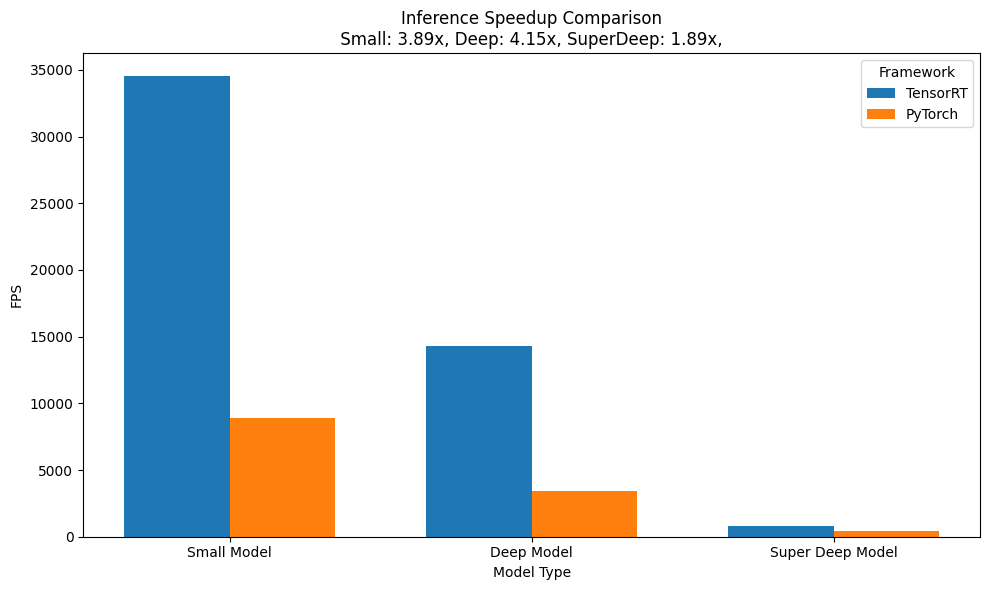

In [98]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data (replace these with your actual values)
# avg_small_model_trt_fps = 150
# avg_small_model_fps = 100
# avg_deep_model_trt_fps = 120
# avg_deep_model_fps = 80
# avg_super_deep_model_trt_fps = 90
# avg_super_deep_model_fps = 60

# Values and labels for the bars
values = [
    [avg_small_model_trt_fps, avg_small_model_fps],
    [avg_deep_model_trt_fps, avg_deep_model_fps],
    [avg_super_deep_model_trt_fps, avg_super_deep_model_fps]
]

speedup_small = avg_small_model_trt_fps/ avg_small_model_fps
speedup_deep = avg_deep_model_trt_fps / avg_deep_model_fps
speedup_super_deep = avg_super_deep_model_trt_fps /  avg_super_deep_model_fps



labels = ['Small Model', 'Deep Model', 'Super Deep Model']
frameworks = ['TensorRT', 'PyTorch']

# Set up the bar positions
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)

# Plotting the bars
for i in range(len(frameworks)):
    ax.bar(x + i * width, [values[j][i] for j in range(len(values))], width, label=frameworks[i])

# Adding titles and labels
ax.set_title(f'Inference Speedup Comparison\n Small: {speedup_small:.2f}x, Deep: {speedup_deep:.2f}x, SuperDeep: {speedup_super_deep:.2f}x, ')
ax.set_xlabel('Model Type')
ax.set_ylabel('FPS')
ax.set_xticks(x + width / 2)
ax.set_xticklabels(labels)
ax.legend(title='Framework')

# Displaying the plot
plt.tight_layout()
plt.show()